In [73]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
from numba import prange

plt.rcParams["figure.figsize"] = (14, 8)
sns.set_style("whitegrid")

## Problem 6.1

In [3]:
def draw_normal(size, theta, seed=0):
    np.random.seed(seed)
    sample = np.random.normal(theta, scale=1, size=size)
    return sample

In [4]:
def critical_value(alpha):
    quantile = scipy.stats.norm.ppf(1 - alpha)
    return quantile

In [5]:
def power_func(theta, alpha, sample_size, theta_0):
    upper_bound = np.sqrt(sample_size) * (theta_0 - theta) - critical_value(alpha)
    power = scipy.stats.norm.cdf(upper_bound)
    return power

### Theoretical Power Function:

In [6]:
powerf = partial(power_func, alpha=0.05, sample_size=100, theta_0=1)

theta_grid = np.linspace(0.5, 1.2, num=1_000)
power = powerf(theta_grid)

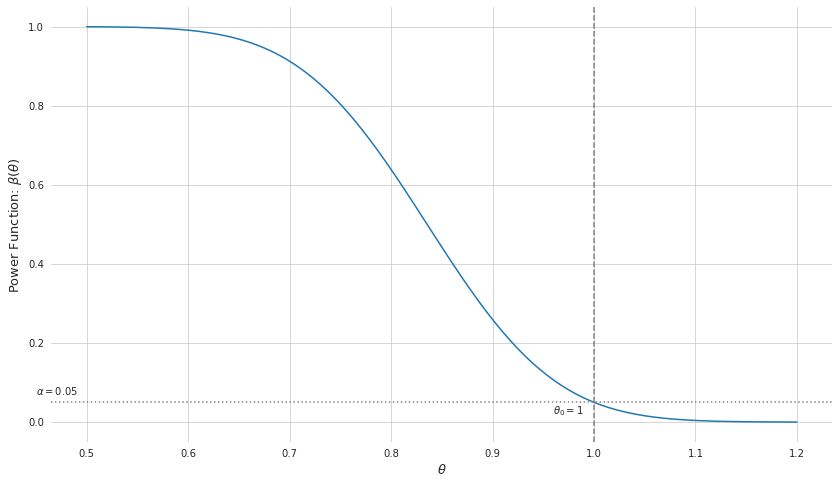

In [7]:
fig, ax = plt.subplots(1)

sns.lineplot(x=theta_grid, y=power, ax=ax)

ax.axvline(1, ls="--", color="grey")
ax.text(0.96, 0.02, r"$\theta_0 = 1$")
ax.axhline(0.05, ls=":", color="grey")
ax.text(0.45, 0.07, r"$\alpha=0.05$")

ax.set(ylabel=r"Power Function: $\beta(\theta)$", xlabel=r"$\theta$")
ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)

In [8]:
def confidence_interval(sample, alpha):
    best_guess = sample.mean()
    crit_value = critical_value(alpha)
    interval = pd.Interval(-np.inf, best_guess + (crit_value / np.sqrt(len(sample))))
    return interval

### Example:

In [9]:
theta = 1.5

sample = draw_normal(size=1_000, theta=theta, seed=1)
ci = confidence_interval(sample, alpha=0.05)
print(f"Confidence Interval: {ci}\n->Theta in CI.\n")

sample = draw_normal(size=1_000, theta=theta, seed=14)
ci = confidence_interval(sample, alpha=0.05)
print(f"Confidence Interval: {ci}\n->Theta not in CI.")

Confidence Interval: (-inf, 1.5908273149471575]
->Theta in CI.

Confidence Interval: (-inf, 1.4639735291422886]
->Theta not in CI.


## Problem 6.2

In [10]:
def moment_of_exponential(n, theta):
    return np.math.factorial(n) * (theta ** n)

In [11]:
def critical_value(alpha):
    quantile = scipy.stats.norm.ppf(1 - alpha / 2)
    return quantile

In [12]:
def draw_exponential(size, theta, seed=0):
    np.random.seed(seed)
    sample = np.random.exponential(scale=theta, size=size)
    return sample

In [13]:
def theta_hat(sample):
    estimate = np.mean(sample, axis=0)
    return estimate

In [14]:
def theta_tilde(sample):
    estimate = np.sqrt(np.mean(sample ** 2, axis=0) / 2)
    return estimate

In [64]:
def standard_error_hat(sample, estimate):
    se = estimate / np.sqrt(len(sample))
    return se

In [65]:
def standard_error_tilde(sample, estimate):
    se = np.sqrt(5 / (4 * len(sample))) * estimate
    return se

In [66]:
def statistic_one(sample, theta_0):
    estimate = theta_hat(sample)
    statistic = (estimate - theta_0) / standard_error_hat(sample, estimate)
    return statistic

In [67]:
def statistic_two(sample, theta_0):
    estimate = theta_tilde(sample)
    statistic = (estimate - theta_0) / standard_error_tilde(sample, estimate)
    return statistic

In [74]:
def finite_sample_power_func(n_grid_points, theta_0, alpha, sample_size, n_runs):
    crit_value = critical_value(alpha)
    theta_grid = np.linspace(1, 3.5, num=n_grid_points)
    power = np.zeros((n_grid_points, 2))
    for i in prange(n_grid_points):
        sample = draw_exponential((sample_size, n_runs), theta_grid[i], seed=i)
        stat_one = statistic_one(sample, theta_0)
        stat_two = statistic_two(sample, theta_0)
        power[i, 0] = (np.abs(stat_one) > crit_value).mean()
        power[i, 1] = (np.abs(stat_two) > crit_value).mean()
    df = pd.DataFrame(np.c_[theta_grid, power], columns=["theta", "hat", "tilde"])
    df = df.melt(id_vars="theta", value_name="power", var_name="estimator_type")
    return df

### Simulated Power Function:

In [75]:
df = finite_sample_power_func(
    n_grid_points=500, theta_0=2, alpha=0.05, sample_size=100, n_runs=10_000
)

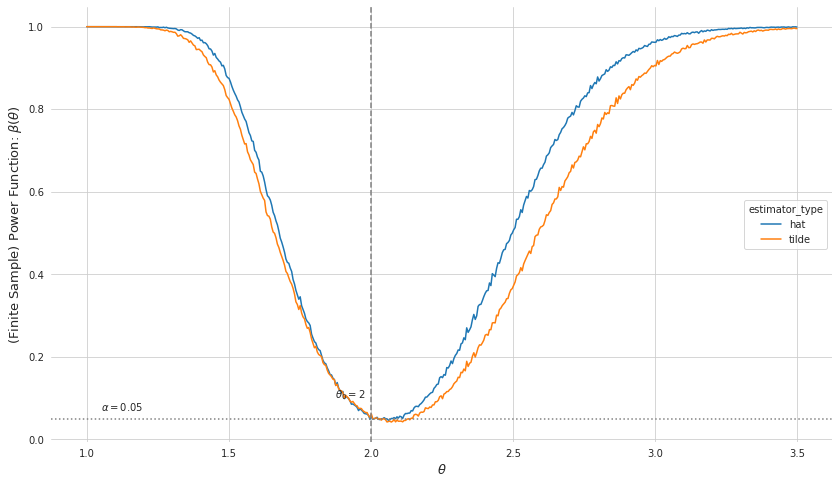

In [76]:
fig, ax = plt.subplots(1)

sns.lineplot(x="theta", y="power", hue="estimator_type", data=df, ax=ax)

ax.axvline(2, ls="--", color="grey")
ax.text(1.875, 0.1, r"$\theta_0 = 2$")
ax.axhline(0.05, ls=":", color="grey")
ax.text(1.05, 0.07, r"$\alpha=0.05$")

ax.set(ylabel=r"(Finite Sample) Power Function: $\beta(\theta)$", xlabel=r"$\theta$")
ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)

## Problem 6.3

In [79]:
df = pd.read_excel("data/SummerWinterData.xlsx").set_index("Year")

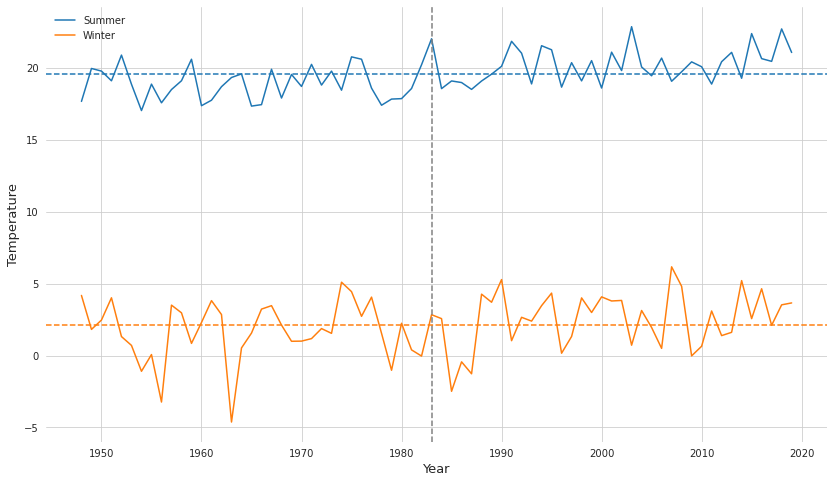

In [80]:
fig, ax = plt.subplots(1)

sns.lineplot(x="Year", y="Temperature", hue="Season", data=df, ax=ax)
ax.axvline(1983, ls="--", color="grey")

means = df.groupby("Season").mean()
ax.axhline(means.loc["Summer"].values, ls="--", color="C0")
ax.axhline(means.loc["Winter"].values, ls="--", color="C1")

ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)
_ = plt.legend(frameon=False)

In [81]:
df_before = df.query("Year <= 1983")
df_after = df.query("Year > 1983")

In [82]:
df_before.groupby("Season").std()

,Temperature
Season,
Summer,1.223441
Winter,2.055581


In [83]:
df_after.groupby("Season").std()

,Temperature
Season,
Summer,1.197797
Winter,1.966947


In [85]:
df_before

,Temperature,Season
Year,,
1948,17.687840,Summer
1949,19.978830,Summer
1950,19.796440,Summer
1951,19.121440,Summer
1952,20.909540,Summer
...,...,...
1979,-1.024359,Winter
1980,2.245838,Winter
1981,0.393642,Winter


In [87]:
def estimator_variance(sample):
    var = sample.var(ddof=1)
    return var / len(sample)

In [207]:
def t_test_statistic(df, season, year):
    sample_before = df.query("Season == @season & Year <= @year")
    sample_after = df.query("Season == @season & Year > @year")
    
    variance = np.sqrt(
        estimator_variance(sample_after) + estimator_variance(sample_before)
    )
    mean_difference = sample_after.mean() - sample_before.mean()
    
    statistic = mean_difference / variance
    return float(statistic)

In [208]:
def t_test(df, season, year=1983, significance_level=0.05):
    crit_value = scipy.stats.norm.ppf(1 - significance_level)
    statistic = t_test_statistic(df, season, year)
    out = (statistic, crit_value)
    return out

In [227]:
def f_test_statistic(df, season, year):
    sample_before = df.query("Season == @season & Year <= @year")
    sample_after = df.query("Season == @season & Year > @year")
    
    sd_before = sample_before.std(ddof=1)
    sd_after = sample_after.std(ddof=1)
    
    statistic = sd_after / sd_before
    return float(statistic), len(sample_before), len(sample_after)

In [228]:
def f_test(df, season, year=1983, significance_level=0.05):
    statistic, n_before, n_after = f_test_statistic(df, season, year)
    crit_value = scipy.stats.f.ppf(1 - significance_level, dfn=n_after, dfd=n_before)
    out = (statistic, crit_value)
    return out

### Reject if left value (realized statistic) is bigger than right value (critical value):

In [234]:
t_test(df, season="Winter")

(1.743153740074438, 1.6448536269514722)

In [235]:
t_test(df, season="Summer")

(4.210129441682203, 1.6448536269514722)

In [232]:
f_test(df, season="Winter")

(0.9568814331184532, 1.7429731651520068)

In [233]:
f_test(df, season="Summer")

(0.9790395894152871, 1.7429731651520068)

Hence, the only hypothesis we reject is that the means in the summer data have not changed after between the two time periods.